<font size="6">**FoF finds halos and plots the halo mass function**</font>

In [1]:
import numpy as np
import h5py
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = '/Users/portia/Documents/Research/Cosmology/Halo/Particle_snap/snap_xyz.h5'

<font size="5">**Halo Analysis**</font>

In [3]:
with h5py.File(file_path, "r") as file:
    # root group
    print("Content is under the root group:", list(file.keys()))
    # Dataset Name
    print("Dataset Name:", list(file.keys()))
    # Read x, y, z coordinate data
    x = file['x_coords'][:]
    y = file['y_coords'][:]
    z = file['z_coords'][:]

Content is under the root group: ['x_coords', 'y_coords', 'z_coords']
Dataset Name: ['x_coords', 'y_coords', 'z_coords']


In [4]:
# Combine coordinates into a single array
coordinates = np.vstack((x, y, z)).T

In [5]:
# Total number of particles
N = len(coordinates)
print(N)

30687185


In [6]:
# Calculate the coordinate ranges for each axis and the estimated Lbox
axes = {'X': x, 'Y': y, 'Z': z}
for axis_name, data in axes.items():
    d_min, d_max = np.min(data), np.max(data)
    Lbox_estimate = d_max - d_min
    print(f"{axis_name}axis range: {d_min:.2f} to {d_max:.2f}, estimated Lbox = {Lbox_estimate:.2f}")

Xaxis range: 0.00 to 50.00, estimated Lbox = 50.00
Yaxis range: 0.00 to 50.00, estimated Lbox = 50.00
Zaxis range: 0.00 to 50.00, estimated Lbox = 50.00


In [7]:
# Chunk reading
chunk_size = 10000
sample_size = 1000000

with h5py.File(file_path, 'r') as file:
    x = file['x_coords']
    y = file['y_coords']
    z = file['z_coords']
    N = len(x)
    
    indices = np.random.choice(N, size=sample_size, replace=False)
    indices.sort()
    
    sampled_coords = []
    for i in range(0, sample_size, chunk_size):
        chunk = slice(i, min(i + chunk_size, sample_size))
        x_chunk = x[indices[chunk]]
        y_chunk = y[indices[chunk]]
        z_chunk = z[indices[chunk]]
        sampled_coords.append(np.column_stack((x_chunk, y_chunk, z_chunk)))
    
    sampled_coords = np.vstack(sampled_coords)

# Periodic boundary conditions
Lbox = 50.0
sampled_coords = sampled_coords % Lbox

# KD tree calculation of nearest neighbor distances
kdtree = cKDTree(sampled_coords, boxsize=Lbox)

# Query the nearest neighbor distance for each sampled particle (excluding itself)
distances, _ = kdtree.query(sampled_coords, k=2)

# Average spacing
d_mean = np.mean(distances[:, 1])
print(f"Average spacing: {d_mean:.6f}")

Average spacing: 0.130893


In [8]:
from halotools.mock_observables import FoFGroups

In [9]:
Lbox = 50.0 
b_perp = 0.2 * d_mean
b_para = 0.2 * d_mean 
nproc = 4

In [10]:
fof_groups = FoFGroups(
    positions = coordinates,
    b_perp = b_perp,
    b_para = b_para,
    period = Lbox,
    num_threads = 4
)

group_ids = fof_groups.group_ids
unique_ids, counts = np.unique(group_ids, return_counts=True)
print(f"Number of unique groups: {len(unique_ids)}")
print("Data processing completed!")

Number of unique groups: 25705572
Data processing completed!


In [11]:
print(f"Group IDs for the first 10000 particles: {group_ids[:10000]}")

print(f"Maximum group size: {np.max(counts)}")
print(f"Minimum group size: {np.min(counts)}")
print(f"Average group size: {np.mean(counts):.2f}")

Group IDs for the first 10000 particles: [   0    1    2 ... 9043 9051 9052]
Maximum group size: 72471
Minimum group size: 1
Average group size: 1.19


In [12]:
# Save group IDs and group size distribution to a file
np.save("group_ids.npy", group_ids)
unique_ids, counts = np.unique(group_ids, return_counts=True)
group_size_distribution = dict(zip(unique_ids, counts))
np.save("group_size_distribution.npy", group_size_distribution)

In [13]:
# Check the number of particles in a specific group
group_size_distribution = np.load("group_size_distribution.npy", allow_pickle=True).item()
group_id = 1234
particle_count = group_size_distribution.get(group_id, "Not found")
print(f"Group ID {group_id} has {particle_count} particles.")

Group ID 1234 has 1 particles.


In [14]:
# Filter out groups with a group size ≥ 20
large_groups = {group_id: count for group_id, count in group_size_distribution.items() if count >= 20}
print("Groups with ≥ 20 particles:")
for group_id, count in large_groups.items():
    print(f"Group ID: {group_id}, Number of particles: {count}")
    
print(f"Total number of groups with ≥ 20 particles: {len(large_groups)}")

Groups with ≥ 20 particles:
Group ID: 4370, Number of particles: 24
Group ID: 8563, Number of particles: 319
Group ID: 14203, Number of particles: 37
Group ID: 15005, Number of particles: 106
Group ID: 16620, Number of particles: 33
Group ID: 20201, Number of particles: 175
Group ID: 21887, Number of particles: 56
Group ID: 22253, Number of particles: 25
Group ID: 23382, Number of particles: 60
Group ID: 23956, Number of particles: 21
Group ID: 24772, Number of particles: 42
Group ID: 25801, Number of particles: 223
Group ID: 29192, Number of particles: 27
Group ID: 32943, Number of particles: 21
Group ID: 32959, Number of particles: 37
Group ID: 33290, Number of particles: 32
Group ID: 35123, Number of particles: 98
Group ID: 38231, Number of particles: 22
Group ID: 38327, Number of particles: 61
Group ID: 38553, Number of particles: 21
Group ID: 41328, Number of particles: 23
Group ID: 42902, Number of particles: 39
Group ID: 43914, Number of particles: 25
Group ID: 45155, Number of 

In [15]:
# Total number and proportion of all particles in groups with a size ≥ 20
N_in_large_groups = sum(large_groups.values())
fraction = N_in_large_groups / N
print(f"Total number of particles in groups with ≥ 20 particles: {N_in_large_groups}")
print(f"Fraction of total particles in these groups: {fraction:.4f}")

Total number of particles in groups with ≥ 20 particles: 2127002
Fraction of total particles in these groups: 0.0693


<font size="5">**Plots halo mass function**</font>

In [16]:
from colossus.cosmology import cosmology
from colossus.lss import mass_function
import numpy as np
import matplotlib.pyplot as plt

In [17]:
plt.rcParams['font.family'] =['Times New Roman']

In [18]:
# Set cosmological parameters
cosmology.setCosmology('planck18')

In [19]:
group_size_distribution = np.load("group_size_distribution.npy", allow_pickle=True).item()

In [20]:
# Filter out halos with a size greater than or equal to 20 particles
large_groups = {group_id: count for group_id, count in group_size_distribution.items() if count >= 20}

# Extract particle count
particle_counts = list(large_groups.values())

# Assume the mass of each particle (unit: h^-1 M_sun)
particle_mass = 3.2e+8 
group_masses = np.array(particle_counts) * particle_mass

In [21]:
# Calculate the mass function
mfunc_data = mass_function.massFunction(group_masses, 0.0, mdef='fof', model='watson13', q_out='dndlnM')

# Create a mass array for model prediction
mass_model = np.logspace(10, 16, 1000) # mass range from 10^10 to 10^16 h^-1 M_sun
mfunc_model = mass_function.massFunction(mass_model, 0.0, mdef='fof', model='watson13', q_out='dndlnM')

In [22]:
# The mass of each halo with a size ≥ 20 particles
for group_id, count in large_groups.items():
    mass = count * particle_mass
    print(f"Group ID: {group_id}, Number of particles: {count}, Mass: {mass} h^-1 M_sun")

Group ID: 4370, Number of particles: 24, Mass: 7680000000.0 h^-1 M_sun
Group ID: 8563, Number of particles: 319, Mass: 102080000000.0 h^-1 M_sun
Group ID: 14203, Number of particles: 37, Mass: 11840000000.0 h^-1 M_sun
Group ID: 15005, Number of particles: 106, Mass: 33920000000.0 h^-1 M_sun
Group ID: 16620, Number of particles: 33, Mass: 10560000000.0 h^-1 M_sun
Group ID: 20201, Number of particles: 175, Mass: 56000000000.0 h^-1 M_sun
Group ID: 21887, Number of particles: 56, Mass: 17920000000.0 h^-1 M_sun
Group ID: 22253, Number of particles: 25, Mass: 8000000000.0 h^-1 M_sun
Group ID: 23382, Number of particles: 60, Mass: 19200000000.0 h^-1 M_sun
Group ID: 23956, Number of particles: 21, Mass: 6720000000.0 h^-1 M_sun
Group ID: 24772, Number of particles: 42, Mass: 13440000000.0 h^-1 M_sun
Group ID: 25801, Number of particles: 223, Mass: 71360000000.0 h^-1 M_sun
Group ID: 29192, Number of particles: 27, Mass: 8640000000.0 h^-1 M_sun
Group ID: 32943, Number of particles: 21, Mass: 6720

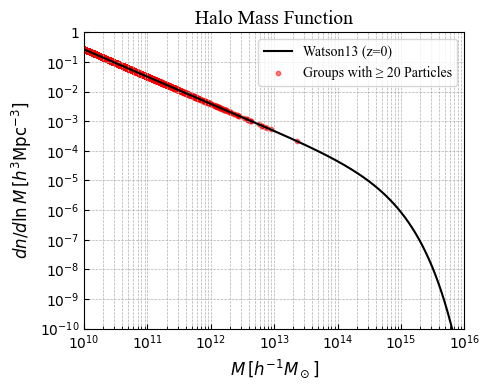

In [23]:
# Plot the graph
plt.figure(figsize=(5, 4))
plt.loglog(mass_model, mfunc_model, 'k-', label='Watson13 (z=0)')
plt.scatter(group_masses, mfunc_data, c='red', s=10, label='Groups with ≥ 20 Particles', alpha=0.5)
plt.xlabel(r'$M \, [h^{-1} M_\odot]$', fontsize=12)
plt.ylabel(r'$dn/d\ln M \, [h^3 \mathrm{Mpc}^{-3}]$', fontsize=12)
plt.title('Halo Mass Function', fontsize=14)
plt.xlim(1e10, 1e16)
plt.ylim(1e-10, 1)
plt.tick_params(direction='in', which='both')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.xticks([1e10, 1e11, 1e12, 1e13, 1e14, 1e15, 1e16],
           [r'$10^{10}$', r'$10^{11}$', r'$10^{12}$', r'$10^{13}$', r'$10^{14}$', r'$10^{15}$', r'$10^{16}$'])
plt.yticks([1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
           [r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$', r'$10^{-6}$', r'$10^{-5}$', r'$10^{-4}$', r'$10^{-3}$', r'$10^{-2}$', r'$10^{-1}$', r'$1$'])
plt.tight_layout()
plt.show()

Starting Mass Function Model Comparison...
Plotting Multiple Mass Function Models...
 Watson et al. 2013 model calculated successfully
 Sheth & Tormen 1999 model calculated successfully
 Press & Schechter 1974 model calculated successfully


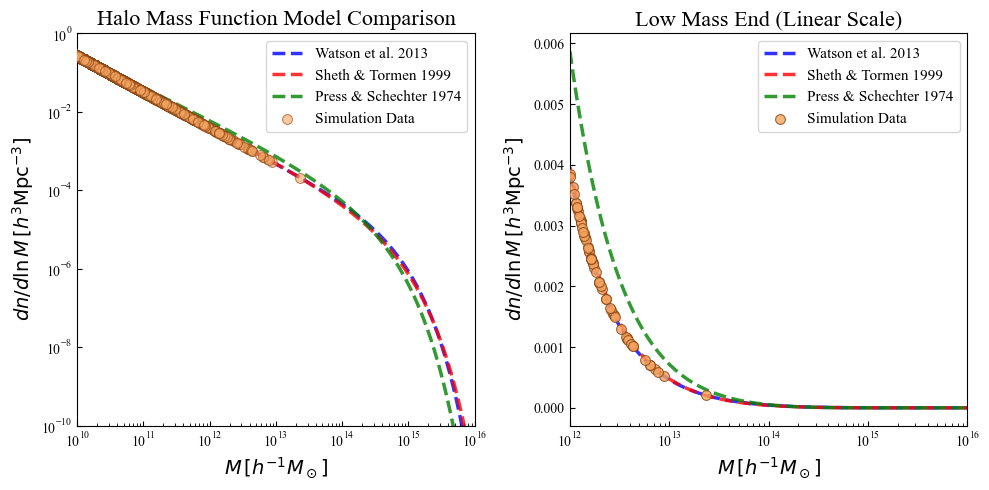

In [24]:
def plot_multiple_mass_function_models(group_masses, mfunc_data_points, Lbox=50.0):
    """
   Compare multiple mass function models: Watson13, Press74, Sheth99
    """
    print("Plotting Multiple Mass Function Models...")
    
    # Set cosmological parameters
    cosmology.setCosmology('planck18')
    
    # Define models to compare
    models = {
        'watson13': {
            'name': 'Watson et al. 2013',
            'color': 'blue',
            'linestyle': '--',
            'linewidth': 2.5
        },
        'sheth99': {
            'name': 'Sheth & Tormen 1999',
            'color': 'red',
            'linestyle': '--',
            'linewidth': 2.5
        },
        'press74': {
            'name': 'Press & Schechter 1974',
            'color': 'green',
            'linestyle': '--',
            'linewidth': 2.5
        },
    }
    
    # Create mass array for model predictions
    mass_model = np.logspace(10, 16, 1000) 
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Main plot: log-log scale
    ax_main = axes[0]
    
    # Calculate and plot each model's mass function
    model_results = {}
    for model_id, model_info in models.items():
        try:
            # Calculate model predictions
            mfunc_model = mass_function.massFunction(
                mass_model, 0.0,
                mdef='fof',
                model=model_id,
                q_out='dndlnM'
            )
            
            model_results[model_id] = {
                'mass': mass_model,
                'mfunc': mfunc_model
            }
            
            # Plot model curves
            ax_main.loglog(
                mass_model, mfunc_model,
                color=model_info['color'],
                linestyle=model_info['linestyle'],
                linewidth=model_info['linewidth'],
                label=model_info['name'],
                alpha=0.8
            )
            
            print(f" {model_info['name']} model calculated successfully")
            
        except Exception as e:
            print(f" Error calculating {model_info['name']}: {e}")
    
    # Plot simulation data points
    if len(group_masses) > 0 and len(mfunc_data_points) > 0:
        ax_main.scatter(
            group_masses, mfunc_data_points,
            c='sandybrown', s=50,
            label='Simulation Data',
            alpha=0.6, edgecolors='saddlebrown', linewidth=0.8,
            zorder=5
        )
    
    # Set main plot properties
    ax_main.set_xlabel(r'$M \, [h^{-1} M_\odot]$', fontsize=14)
    ax_main.set_ylabel(r'$dn/d\ln M \, [h^3 \mathrm{Mpc}^{-3}]$', fontsize=14)
    ax_main.set_title('Halo Mass Function Model Comparison', fontsize=16, fontweight='light')
    ax_main.set_xlim(1e10, 1e16)
    ax_main.set_ylim(1e-10, 1)
    ax_main.grid(False)
    ax_main.tick_params(direction='in', which='both')
    ax_main.legend(fontsize=11, loc='upper right')
    
    # Subplot 2: Linear Y-axis scale (focus on high mass end)
    ax_linear = axes[1]
    
    for model_id, model_info in models.items():
        if model_id in model_results:
            # Only show high mass end
            mask = mass_model >= 1e12
            ax_linear.semilogx(
                mass_model[mask], model_results[model_id]['mfunc'][mask],
                color=model_info['color'],
                linestyle=model_info['linestyle'],
                linewidth=model_info['linewidth'],
                label=model_info['name'],
                alpha=0.8
            )
    
    if len(group_masses) > 0 and len(mfunc_data_points) > 0:
        mask_sim = group_masses >= 1e12
        if np.any(mask_sim):
            ax_linear.scatter(
                group_masses[mask_sim], mfunc_data_points[mask_sim],
                c='sandybrown', s=50,
                label='Simulation Data',
                alpha=0.8, edgecolors='saddlebrown', linewidth=0.8,
                zorder=5
            )
    
    ax_linear.set_xlabel(r'$M \, [h^{-1} M_\odot]$', fontsize=14)
    ax_linear.set_ylabel(r'$dn/d\ln M \, [h^3 \mathrm{Mpc}^{-3}]$', fontsize=14)
    ax_linear.set_title('Low Mass End (Linear Scale)', fontsize=16)
    ax_linear.set_xlim(1e12, 1e16)
    ax_linear.grid(False)
    ax_linear.tick_params(direction='in', which='both')
    ax_linear.legend(fontsize=11)
    
    plt.tight_layout()
    plt.show()
    
    return model_results

print("Starting Mass Function Model Comparison...")

try:
    # Run multi-model comparison
    model_comparison = plot_multiple_mass_function_models(
        group_masses, mfunc_data, Lbox=50.0
    )
    
    # print("\n Mass function model comparison completed successfully")
    
except NameError:
    print("Please run the halo analysis code first to generate group_masses and mfunc_data")
    print("Or use the following example to test the function:")

# Save comparison results
def save_model_comparison(model_results, filename="mass_function_comparison.txt"):
    
    with open(filename, 'w') as f:
        f.write("Mass Function Model Comparison Results\n")
        f.write("="*50 + "\n\n")
        
        f.write("Models compared:\n")
        f.write("- Watson et al. 2013 (watson13)\n")
        f.write("- Press & Schechter 1974 (press74)\n")
        f.write("- Sheth & Tormen 1999 (sheth99)\n\n")
        
        f.write("Mass [h^-1 M_sun]\tWatson13\tPress74\tSheth99\n")
        
        mass_points = np.logspace(11, 15, 20)
        for M in mass_points:
            f.write(f"{M:.2e}")
            
            for model_id in ['watson13', 'press74', 'sheth99']:
                if model_id in model_results:
                    # Interpolate to get value at corresponding mass
                    mfunc_interp = np.interp(M,
                                           model_results[model_id]['mass'],
                                           model_results[model_id]['mfunc'])
                    f.write(f"\t{mfunc_interp:.3e}")
                else:
                    f.write(f"\tN/A")
            f.write("\n")